In [1]:
import sys
import torch_geometric as pyg
from scipy.sparse.linalg import eigs, eigsh


sys.path.append("/nfs/homedirs/reiffers/consistency-based-sheaf-diffusion")

import torch
import torch.nn as nn
import torch_geometric.transforms as T

from omegaconf import DictConfig, OmegaConf

# from cbsd.nn.models.consistency_snn import CSNN
from cbsd.nn.models import EnergyGCN2

from cbsd.nn.builders import ConnectionLaplacianBuilder
from cbsd.baselines.nsd_reproduction.models.nsd import (
    DiscreteGeneralSheafDiffusionEnergy,
)

from cbsd.config import instantiate_datamodule

from torch_geometric.transforms.laplacian_lambda_max import LaplacianLambdaMax
from torch_geometric.utils import to_scipy_sparse_matrix, to_edge_index

device = "cuda" if torch.cuda.is_available() else "cpu"

No CUDA runtime is found, using CUDA_HOME='/nfs/shared/cuda/11.7'


In [2]:
# Load data
config = OmegaConf.load(
    "/nfs/homedirs/reiffers/consistency-based-sheaf-diffusion/config/exec.yaml"
)

dataconfig = OmegaConf.load(
    "/nfs/homedirs/reiffers/consistency-based-sheaf-diffusion/config/data/texas.yaml"
)

config["data"] = OmegaConf.merge(config["data"], dataconfig)

print(OmegaConf.to_yaml(config))


datamodule = instantiate_datamodule(config.data)
datamodule.prepare_data()
datamodule.setup()

lambda_max = LaplacianLambdaMax(normalization="sym", is_undirected=True)
datamodule.edge_attr = None
lambda_max(datamodule)
print(f"Laplacian Lambda max: {datamodule.lambda_max}")

defaults:
- data: null
- task: node_classification
- hydra: default
- model: null
- _self_
store_data_path: /ceph/hdd/students/reiffers/cbsd
data:
  root: ${store_data_path}/datasets
  name: texas
  collection: WebKB
  normalize_features: true
  to_undirected: true
  remove_self_loops: true
  split_idx: 0
  dim_reduction: false
  dr_method: pca
  dr_dimension: 128
seed: null
eval_testset: true
trainer:
  _target_: pytorch_lightning.Trainer
  accelerator: gpu
  devices: 1
  max_epochs: 10000
  log_every_n_steps: 10
  gradient_clip_val: null
  resume_from_checkpoint: null
early_stopping: 200
wandb:
  id: null
  entity: consistency-based-sheaf-diffusion
  project: cbsd
  group: null
  dir: ${store_data_path}
  name: null
  mode: null
hydra:
  job:
    name: ${wandb.group}

Laplacian Lambda max: 1.9376230239868164


In [3]:
# Precompute laplacian
# conf = OmegaConf.load(
#     "/nfs/homedirs/reiffers/consistency-based-sheaf-diffusion/config/model/snn.yaml"
# )
# print(conf)
# builder = ConnectionLaplacianBuilder(conf.sheaf_laplacian)
# texas_lap = builder.build(x=datamodule.x.to(device), edge_index=datamodule.edge_index.to(device))
# texas_datamodule = datamodule
# edge_index, edge_weight = to_edge_index(texas_lap)
# L = to_scipy_sparse_matrix(edge_index, edge_weight, num_nodes=texas_datamodule.num_nodes*conf.sheaf_laplacian.d)

# lambda_max = eigsh(L, k=1, which='LM', return_eigenvectors=False)
# print(f'Sheaf Laplacian Lambda max: {float(lambda_max.real)}')

In [4]:
def run(data, num_layers, left_weights, right_weights, normalized=True):
    model = DiscreteGeneralSheafDiffusionEnergy(
        in_channels=data.num_features,
        hidden_channels=16,
        d=3,
        num_layers=num_layers,
        num_nodes=data.num_nodes,
        edge_index=data.edge_index.to(device),
        out_channels=data.num_classes,
        left_weights=left_weights,
        right_weights=right_weights,
        linear=True,
        normalized_energy=normalized,
        residual=True,
        use_act=False,
        dropout=0,
    ).to(device)

    with torch.no_grad():
        model.eval()
        sheaf_energies, energies = model(data.x.to(device))
    return {
        "Sheaf Energy": torch.FloatTensor(sheaf_energies).cpu(),
        "Energy": torch.FloatTensor(energies).cpu(),
    }

In [13]:
texas_datamodule = datamodule
num_layers = 64
output1 = run(
    data=texas_datamodule,
    num_layers=num_layers,
    left_weights=False,
    right_weights=False,
)
output2 = run(
    data=texas_datamodule,
    num_layers=num_layers,
    left_weights=False,
    right_weights=True,
)
output3 = run(
    data=texas_datamodule,
    num_layers=num_layers,
    left_weights=True,
    right_weights=False,
)
output4 = run(
    data=texas_datamodule,
    num_layers=num_layers,
    left_weights=True,
    right_weights=True,
)

energies1 = output1["Sheaf Energy"]
energies2 = output2["Sheaf Energy"]
energies3 = output3["Sheaf Energy"]
energies4 = output4["Sheaf Energy"]
# similarities = output["Feature Similarity"][1:]
print(energies1)
print(energies2)
print(energies3)
print(energies4)

1.6170681715011597
1.617067575454712
1.6170681715011597
1.617067813873291
tensor([0.1543, 1.5384, 1.5825, 1.5803, 1.5675, 1.5401, 1.4926, 1.4102, 1.2788,
        1.0867, 0.8496, 0.6088, 0.4123, 0.2777, 0.1970, 0.1516, 0.1267, 0.1129,
        0.1047, 0.0994, 0.0956, 0.0925, 0.0898, 0.0874, 0.0851, 0.0829, 0.0807,
        0.0785, 0.0764, 0.0743, 0.0722, 0.0702, 0.0681, 0.0661, 0.0641, 0.0621,
        0.0601, 0.0582, 0.0564, 0.0545, 0.0527, 0.0510, 0.0493, 0.0477, 0.0461,
        0.0445, 0.0430, 0.0416, 0.0402, 0.0389, 0.0376, 0.0364, 0.0352, 0.0340,
        0.0329, 0.0318, 0.0307, 0.0297, 0.0287, 0.0277, 0.0268, 0.0259, 0.0250,
        0.0241, 0.0232])
tensor([0.2638, 1.5404, 1.5537, 1.5579, 1.5763, 1.5749, 1.5803, 1.5968, 1.5953,
        1.6044, 1.6066, 1.6070, 1.6082, 1.6117, 1.6100, 1.6061, 1.6070, 1.6084,
        1.6098, 1.6024, 1.5966, 1.6053, 1.5891, 1.6038, 1.6040, 1.5967, 1.6071,
        1.6084, 1.6118, 1.6128, 1.6139, 1.6143, 1.6145, 1.6154, 1.6161, 1.6160,
        1.6161, 1.616

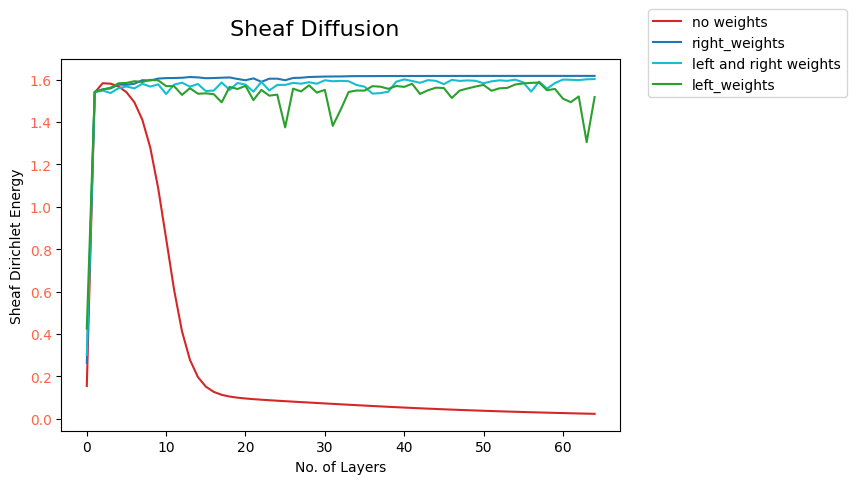

In [14]:
import matplotlib.pyplot as plt

layers = range(num_layers + 1)

fig, ax1 = plt.subplots()

ax1.set_xlabel("No. of Layers")
ax1.set_ylabel("Sheaf Dirichlet Energy")
# ax1.set_yscale("log")
ax1.plot(layers, energies1, color="tab:red", label="no weights")
ax1.plot(layers, energies2, color="tab:blue", label="right_weights")
ax1.plot(layers, energies4, color="tab:cyan", label="left and right weights")
ax1.plot(layers, energies3, color="tab:green", label="left_weights")


ax1.tick_params(axis="y", labelcolor="tomato")

# ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

# ax2.set_yscale("log")

# ax2.plot(layers, energies2, color="tab:blue", label="right_weights")
# ax2.plot(layers, energies4, color="tab:cyan", label="left and right weights")
# ax2.plot(layers, energies3, color="tab:green", label="left_weights")

# ax2.tick_params(axis="y", labelcolor="steelblue")

fig.suptitle("Sheaf Diffusion", fontsize=16)

fig.legend(bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0)
fig.tight_layout()  # otherwise the right y-label is slightly clipped

plt.show()

In [15]:
energies1 = output1["Energy"]
energies2 = output2["Energy"]
energies3 = output3["Energy"]
energies4 = output4["Energy"]
# similarities = output["Feature Similarity"][1:]
print(energies1)
print(energies2)
print(energies3)
print(energies4)

tensor([3.9354e-02, 1.1906e+01, 2.5682e+01, 1.4588e+01, 2.9665e+01, 1.1123e+01,
        3.5708e+01, 5.5263e+00, 4.4250e+01, 1.0581e+00, 5.0288e+01, 4.5059e+00,
        4.6486e+01, 1.3409e+01, 3.8107e+01, 1.9708e+01, 3.1606e+01, 2.2342e+01,
        2.7489e+01, 2.2852e+01, 2.4812e+01, 2.2367e+01, 2.2888e+01, 2.1467e+01,
        2.1364e+01, 2.0423e+01, 2.0075e+01, 1.9376e+01, 1.8950e+01, 1.8393e+01,
        1.7966e+01, 1.7504e+01, 1.7121e+01, 1.6746e+01, 1.6426e+01, 1.6128e+01,
        1.5888e+01, 1.5674e+01, 1.5516e+01, 1.5389e+01, 1.5317e+01, 1.5274e+01,
        1.5279e+01, 1.5323e+01, 1.5409e+01, 1.5529e+01, 1.5684e+01, 1.5880e+01,
        1.6103e+01, 1.6356e+01, 1.6640e+01, 1.6935e+01, 1.7268e+01, 1.7610e+01,
        1.7975e+01, 1.8348e+01, 1.8734e+01, 1.9129e+01, 1.9530e+01, 1.9936e+01,
        2.0344e+01, 2.0752e+01, 2.1157e+01, 2.1558e+01, 2.1950e+01])
tensor([ 0.0303, 11.6898, 13.5978, 14.0539, 15.6277, 15.5750, 17.1384, 18.4835,
        17.1868, 18.2272, 18.3359, 17.7334, 17.8518

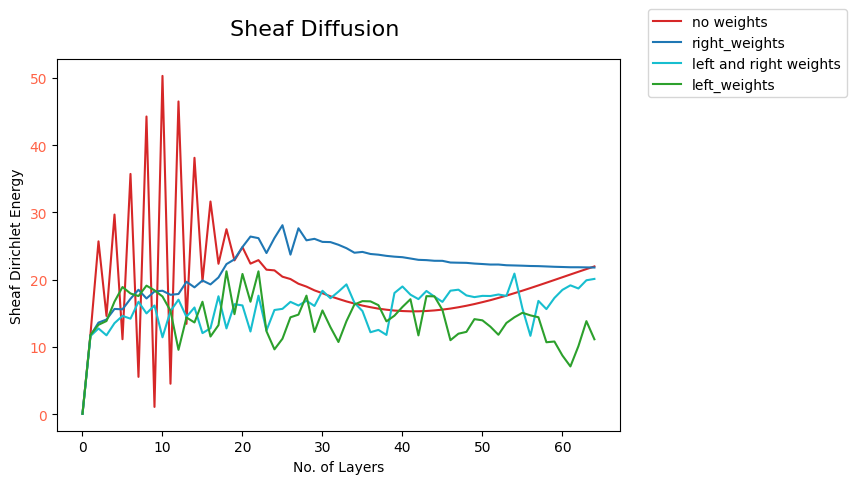

In [16]:
import matplotlib.pyplot as plt

layers = range(num_layers + 1)

fig, ax1 = plt.subplots()

ax1.set_xlabel("No. of Layers")
ax1.set_ylabel("Sheaf Dirichlet Energy")
# ax1.set_yscale("log")
ax1.plot(layers, energies1, color="tab:red", label="no weights")
ax1.plot(layers, energies2, color="tab:blue", label="right_weights")
ax1.plot(layers, energies4, color="tab:cyan", label="left and right weights")
ax1.plot(layers, energies3, color="tab:green", label="left_weights")


ax1.tick_params(axis="y", labelcolor="tomato")

# ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

# ax2.set_yscale("log")

# ax2.plot(layers, energies2, color="tab:blue", label="right_weights")
# ax2.plot(layers, energies4, color="tab:cyan", label="left and right weights")
# ax2.plot(layers, energies3, color="tab:green", label="left_weights")

# ax2.tick_params(axis="y", labelcolor="steelblue")

fig.suptitle("Sheaf Diffusion", fontsize=16)

fig.legend(bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0)
fig.tight_layout()  # otherwise the right y-label is slightly clipped

plt.show()

In [9]:
def runGCN(data, num_layers, right_weights):
    model = EnergyGCN2(
        num_nodes=data.num_nodes,
        in_channels=data.num_features,
        hidden_channels=16,
        out_channels=data.num_classes,
        edge_index=data.edge_index.to(device),
        right_weights=right_weights,
        num_layers=num_layers,
        use_act=True,
        residual=True,
        normalized_energy=True,
    ).to(device)

    with torch.no_grad():
        model.eval()
        energies = model(data.x.to(device))
    # for layer in range(len(model.lin_right_weights)):
    #     print(model.lin_right_weights[layer].spectral_norm)

    return {"Dirichlet energy": torch.FloatTensor(energies).cpu()}

In [10]:
texas_datamodule = datamodule
num_layers = 32
output1gcn = runGCN(
    data=texas_datamodule,
    num_layers=num_layers,
    right_weights=False,
)
output2gcn = runGCN(
    data=texas_datamodule,
    num_layers=num_layers,
    right_weights=True,
)

energies1gcn = output1gcn["Dirichlet energy"]
energies2gcn = output2gcn["Dirichlet energy"]
# similarities = output["Feature Similarity"][1:]
print(energies1gcn)
print(energies2gcn)

# print(similarities)

tensor([0.3579, 1.6841, 1.7838, 1.8192, 1.8382, 1.8500, 1.8582, 1.8645, 1.8696,
        1.8739, 1.8778, 1.8814, 1.8848, 1.8880, 1.8911, 1.8942, 1.8972, 1.9000,
        1.9028, 1.9056, 1.9082, 1.9107, 1.9130, 1.9153, 1.9174, 1.9193, 1.9211,
        1.9228, 1.9243, 1.9257, 1.9270, 1.9281, 1.9291])
tensor([0.3578, 1.6796, 1.6760, 1.6905, 1.7027, 1.7216, 1.7308, 1.7216, 1.7552,
        1.7572, 1.7521, 1.7653, 1.7481, 1.7560, 1.7463, 1.7537, 1.7518, 1.7884,
        1.7722, 1.7676, 1.7728, 1.7553, 1.7526, 1.7577, 1.7585, 1.7162, 1.7554,
        1.7622, 1.7607, 1.7614, 1.7566, 1.7712, 1.7680])


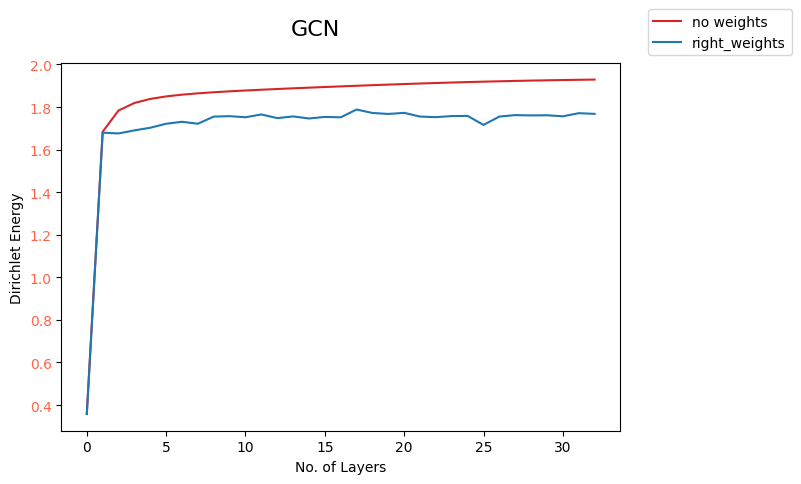

In [11]:
import matplotlib.pyplot as plt

layers = range(num_layers + 1)

fig, ax1 = plt.subplots()

ax1.set_xlabel("No. of Layers")
ax1.set_ylabel("Dirichlet Energy")
# ax1.set_yscale("log")
ax1.plot(layers, energies1gcn, color="tab:red", label="no weights")
ax1.plot(layers, energies2gcn, color="tab:blue", label="right_weights")


ax1.tick_params(axis="y", labelcolor="tomato")

# ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

# ax2.set_yscale("log")

# ax2.plot(layers, energies2gcn, color="tab:blue", label="right_weights")

# ax2.tick_params(axis="y", labelcolor="steelblue")

fig.suptitle("GCN", fontsize=16)

fig.legend(bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0)
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

ValueError: x and y must have same first dimension, but have shapes (32,) and torch.Size([33])

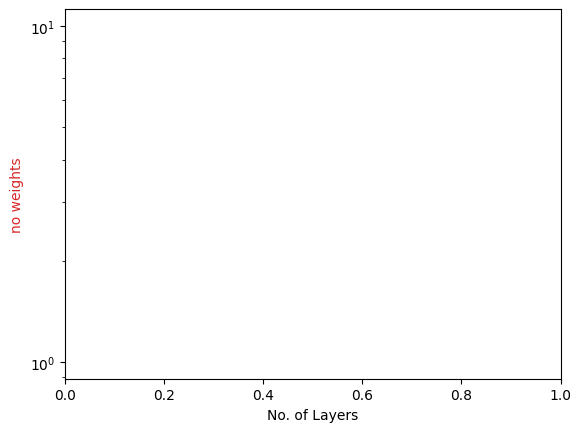

In [12]:
import matplotlib.pyplot as plt

layers = range(num_layers)

fig, ax1 = plt.subplots()

color = "tab:red"
ax1.set_xlabel("No. of Layers")
ax1.set_ylabel("no weights", color=color)
ax1.set_yscale("log")
ax1.plot(layers, energies1, color=color, label="Conn-NSD")

ax1.tick_params(axis="y", labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = "tab:blue"
ax2.set_ylabel(
    "right_weights", color=color
)  # we already handled the x-label with ax1
ax2.set_yscale("log")

ax2.plot(layers, energies2, color=color)

ax2.tick_params(axis="y", labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = "tab:green"
ax2.set_ylabel(
    "left_weights", color=color
)  # we already handled the x-label with ax1
ax2.set_yscale("log")

ax2.plot(layers, energies3, color=color)

ax2.tick_params(axis="y", labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = "tab:orange"
ax2.set_ylabel(
    "left and right weights", color=color
)  # we already handled the x-label with ax1
ax2.set_yscale("log")

ax2.plot(layers, energies4, color=color)

ax2.tick_params(axis="y", labelcolor=color)

fig.suptitle("Texas dataset - Sheaf Energy", fontsize=16)

fig.legend()
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()